# Part 3 : Restoration

In this part of the TP, we are going to look at image restoration. We will look at several type of noise and ways to remove this noise. We first define some helper functions.

### Your task

In the lab work, you must fill in the code in the places marked FILL IN CODE, or answer the written questions directly on the notebook.

--2021-01-20 16:44:02--  https://perso.telecom-paristech.fr/anewson/doc/images/palma.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.2.165, 2001:660:330f:2::a5
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.2.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 770583 (753K) [image/png]
Saving to: ‘palma.png.4’

palma.png.4         100%[===================>] 752.52K  1.99MB/s    in 0.4s    

2021-01-20 16:44:03 (1.99 MB/s) - ‘palma.png.4’ saved [770583/770583]



(600, 800)

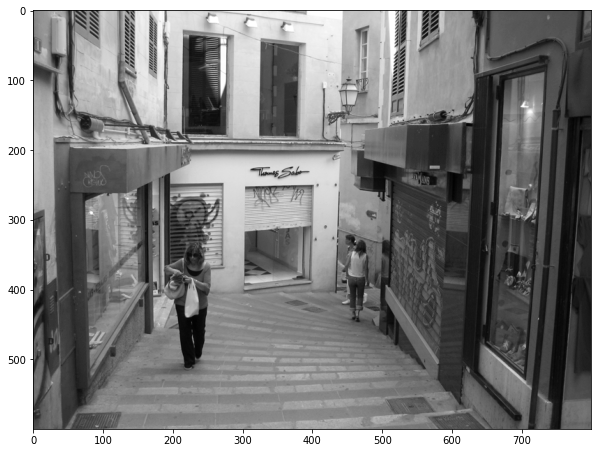

In [25]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = True


def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

We will look at the following noise types :

- Gaussian noise
- Impulse (salt-and-pepper, 0 or 1) noise
- Missing pixels

Fill in the following functions to add this noise to a gray-level image. Do not forget to clip the pixe values to the range $(0,1)$ (np.clip).

In [26]:
def add_gaussian_noise(img_in,sigma_noise = 0.01):
    img_shape = img_in.shape
    noise = np.random.normal(loc=0.0, scale=sigma_noise, size=img_shape)
    img_out = img_in + noise
    img_out = np.clip(img_out,a_min=0,a_max=1)
    return img_out

# we define the impulse probability p as the probability of a pixel not being affected
def add_impulse_noise(img_in,p=0.9):
    img_shape = img_in.shape
    img_out = np.ndarray(img_shape)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if  np.random.binomial(1,p)==0:
                img_out[i,j] = np.random.binomial(1,0.5)
            else:
                img_out[i,j] = img_in[i,j]
    return img_out

def add_missing_pixels_noise(img_in,p=0.9):
    img_shape = img_in.shape
    img_out = np.ndarray(img_shape)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if  np.random.binomial(1,p)==0:
                img_out[i,j] = 0
            else:
                img_out[i,j] = img_in[i,j]
    return img_out

Add the different noises to the input image, and display (or write) the results. Use the following parameters :

- sigma_noise=0.05 for the gaussian noise
- $p=0.9$ (the probability of a pixel __not__ being affected, for the impulse noise and missing pixels

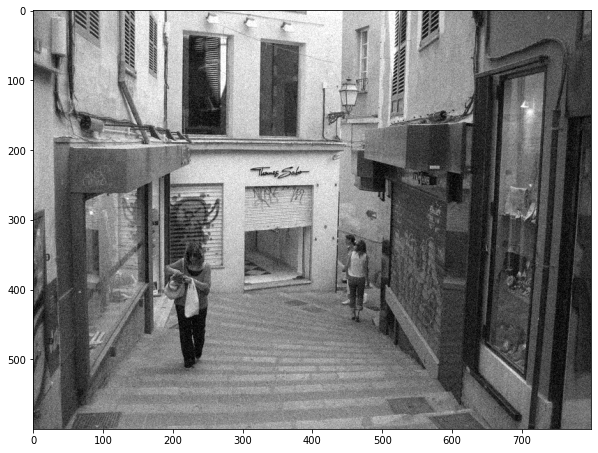

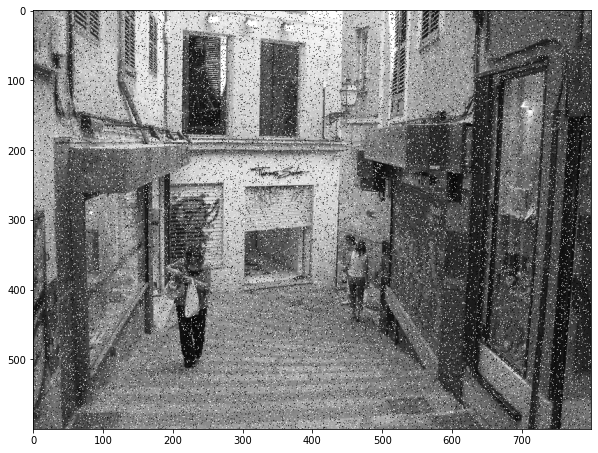

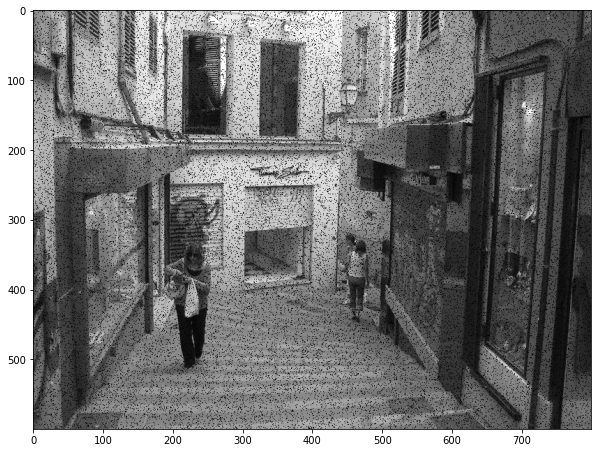

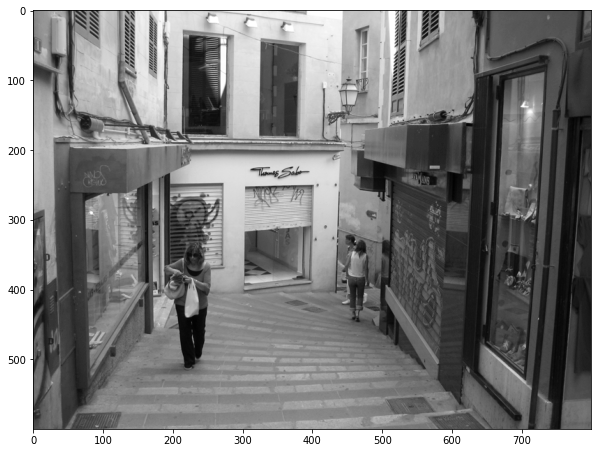

In [27]:
sigma_noise = 0.05
img_gray_gaussian = add_gaussian_noise(img_gray, sigma_noise)
write_image(img_gray_gaussian,file_name+'_gaussian_noise.png')
display_image(img_gray_gaussian)
img_gray_impulse = add_impulse_noise(img_gray, 0.9)
write_image(img_gray_impulse,file_name+'_impulse_noise.png')
display_image(img_gray_impulse)
img_gray_missing = add_missing_pixels_noise(img_gray, 0.9)
write_image(img_gray_missing,file_name+'_missing_pixels.png')
display_image(img_gray_missing)
display_image(img_gray)

__Question__ For each type of noise, propose a restoration filter (see course slides).

__Answer__ For the gaussian noise, we use a gaussian filter. For the Impulse and missing pixels noise we use a median filter.

Implement these restoration filters in appropriately named functions, and write the corresponding output images. Try to find the parameters which give the best results (visually).

__IMPORTANT NOTE__, you can use the filtering functions of the ``scipy.ndimage`` package, where the filtering is already implemented (do not re-implement the filters)

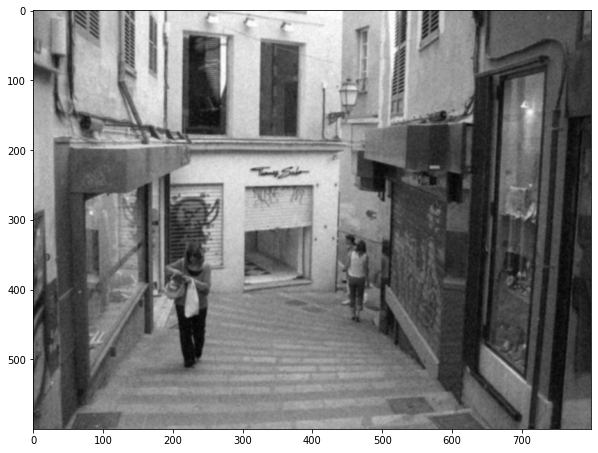

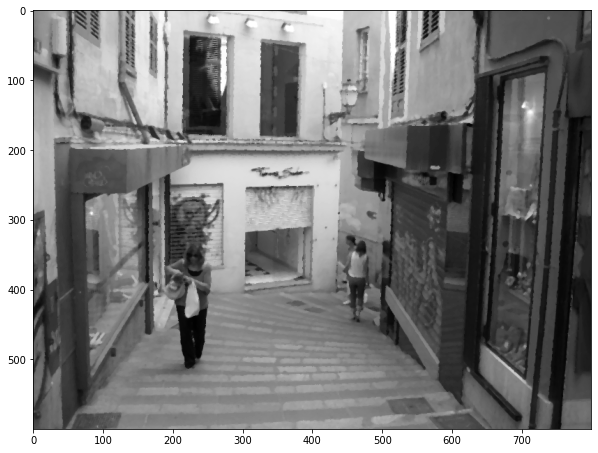

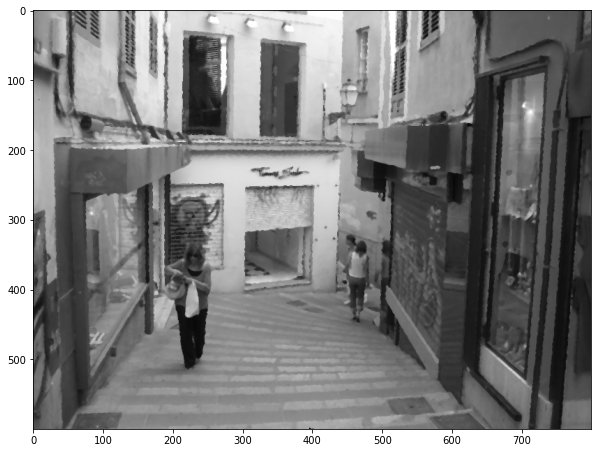

In [28]:
from scipy import ndimage

restored_Gaussian = ndimage.gaussian_filter(img_gray_gaussian,sigma=1)
display_image(restored_Gaussian)
restored_Impulse = ndimage.median_filter(img_gray_impulse, size=4)
display_image(restored_Impulse)
restored_Missing = ndimage.median_filter(img_gray_missing, size=4) 
display_image(restored_Missing)


__Question__ Roughly speaking, what is the tradeoff which you are trying to achieve by tuning the parameters ?

__Answer__  If we try to remove the noise completely, we may lost information, so we need to tune the parameters in order to restore the image the most while we keep the important information contained in the image.

### Evaluation

A commonly used metric for denoising is the ''Peak Signal-to-Noise Ratio'' (PSNR). This is linked to the commonly known mean squared error. The mean squared error is defined, for a reference image $Y$ and a restored image $Y$, of size $m \times n$ as :

- MSE$(Y,I) = \frac{1}{mn} \sum_{x,y} \left( I_{x,y} - Y_{x,y}\right)^2 $

The PSNR is defined, in Decibels, as :

PSNR$(Y,I) = 10 * \log{\left( \frac{I_{max}^2}{MSE(Y,I)} \right)}$,

where $I_{max}$ is the maximum value of the image. For us (normalised to 1), this gives :

PSNR$(Y,I) = -10 * \log{ \left({MSE(Y,I)} \right)}$.

Implement this in a function, and create a code to plot the PSNR for several values of the paramter, __in the Gaussian case only (first filter)__. 

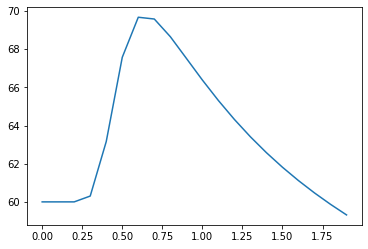

In [29]:
def PSNR(img,img_ref):
    img_shape = img_ref.shape
    mse = np.max(img_ref)**2/(img_shape[0] * img_shape[1])*np.sum((img_ref - img)**2)
    psnr = -10 * np.log(mse)
    return psnr

sigmas = np.arange(0,2,0.1)
PSNR_list = []
for s in sigmas:
    PSNR_list.append(PSNR(ndimage.gaussian_filter(img_gray_gaussian,s),img_gray))

plt.plot(sigmas,PSNR_list)

## POUR ALLER PLUS LOIN (PARTIE PAS OBLIGATOIRE)

## Deconvolution

In this part of the TP, we are going to try and invert a convolution operation. This is called __deconvolution__, and can be carried out in the Fourier domain, as follows. For an image $I$, filter $f$ and an output $Y$, if we have :

$Y = I \ast f$,

then using the convolution theorem (see lesson), we have :

$I = \text{IFFT}\left(\frac{\hat{Y}}{\hat{f}}\right)$

where $\hat{Y}$ and $\hat{f}$ are the Fourier transforms of $Y$ and $f$ respectively.

To simplify the problem, we take a square image for this part of the TP.


In [30]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

FileNotFoundError: ignored

Now, let us consider the following fiter, defined in the Fourier domain :

In [ ]:
from scipy import signal

img_size = img_gray.shape[0]
h_size = int(np.floor(img_size/2.0))
f_hat = np.zeros((img_size,img_size))

X = np.asarray(range(-h_size,h_size))
f_hat = np.tile( np.expand_dims( np.exp(-( X**2) / (2.0*(20.0**2))) , axis=1), (1,img_size)).T
f_hat /= f_hat.sum()
f_hat = np.fft.ifftshift(f_hat)
plt.imshow( np.log( np.abs(f_hat)+1), cmap = 'gray')

print(f_hat.shape)

Using the convolution theorem and the inverse Fourier transform, carry out the convolution of the input image with $f$ (in the Fourier domain, so using $\hat{f}$) and write the result ``img_convolved`` to an output file

__Question__ What does this filter do (you can use the visualisation method from the first part of the TP to see what the filter spectrum looks like) ? __Bonus__ How can this happen in real life ? 

In [ ]:
img_convolved = # FILL IN CODE

img_convolved -= img_convolved.min()
img_convolved /= img_convolved.max()

write_image(img_convolved,file_name+'_convolution.png')
img_convolved.max()

__Answer__ 

Now, create a function which carries out a deconvolution in the Fourier domain, given an image and the Fourier transform of the filter $\hat{f}$. You can reuse the code in the first part of the TP. Carry out the deconvolution on ``img_convolved`` and write the result to an output file. Remember to renormalise the output image.

__Important note__ : You will have a problem with very small values of $\hat{f}$ (division by 0). Propose a simple method to address this issue.


In [ ]:
def deconvolve_fourier(img,f_hat):
    # FILL IN CODE
    return img_out
    

img_out = np.real(deconvolve_fourier(img_convolved,f_hat))
img_out -= img_out.min()
img_out /= img_out.max()


write_image(img_out,file_name+'_deconvolved.png')